In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.metrics import mean_squared_error, r2_score 

import pandas as pd
from sklearn.impute import SimpleImputer #handle datamissing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer #categorical column
import seaborn as sns #for Correlation matrix
#this for spillit and scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib # Save the best model (poly_pipeline)




# 🛠️ Production Environment Setup

---

> 💡 **Pro Tip:** Think of this step as setting the foundation of a building — if it’s strong and well-organized, everything built on top will be reliable, scalable, and easier to maintain.


In [1]:
# 🛠️ Advanced imports for production ML

# Suppress warnings for cleaner outputs
import warnings
warnings.filterwarnings('ignore')

# 🔧 Core Python libraries
import numpy as np           # Efficient numerical computations
import pandas as pd          # Data manipulation and analysis
import matplotlib.pyplot as plt  # Basic plotting
import seaborn as sns        # Advanced visualization
from scipy import stats      # Statistical functions
import joblib               # Save/load large models and preprocessing objects
import json                 # Handle JSON configs and outputs
from datetime import datetime  # Timestamping for logs
import os                   # File system operations
import time                 # Time tracking for experiments



# 🧰 Sklearn libraries - expanded for advanced ML workflows

from sklearn.model_selection import (
    train_test_split,     # Split data into train/test sets
    cross_val_score,      # Cross-validation scoring
    GridSearchCV,         # Hyperparameter tuning (grid search)
    RandomizedSearchCV    # Hyperparameter tuning (randomized search)
)
from sklearn.preprocessing import (
    StandardScaler,       # Feature scaling (zero-mean, unit variance)
    RobustScaler,         # Scaling robust to outliers
    PolynomialFeatures    # Generate polynomial features for non-linear relationships
)
from sklearn.pipeline import Pipeline, FeatureUnion  # Build modular pipelines
from sklearn.compose import ColumnTransformer         # Apply different preprocessing to columns
from sklearn.feature_selection import (
    SelectKBest,          # Univariate feature selection
    f_regression,         # Scoring function for regression
    RFE                   # Recursive feature elimination
)
from sklearn.linear_model import (
    LinearRegression,     # Baseline regression
    Ridge,                # L2-regularized regression
    Lasso,                # L1-regularized regression
    ElasticNet            # Combination of L1 and L2 regularization
)
from sklearn.ensemble import (
    RandomForestRegressor,       # Ensemble of decision trees
    GradientBoostingRegressor,   # Boosted trees for regression
    VotingRegressor              # Combine multiple regressors
)
from sklearn.svm import SVR               # Support Vector Regression
from sklearn.metrics import (
    mean_squared_error,  # Regression metric
    r2_score,            # Regression metric
    mean_absolute_error  # Regression metric
)
from sklearn.inspection import (
    permutation_importance,       # Feature importance
    PartialDependenceDisplay      # Partial dependence plots
)

# 🧪 Advanced model tracking with MLflow
import mlflow                  # Experiment tracking
import mlflow.sklearn          # Log sklearn models
from mlflow.models.signature import infer_signature  # Auto-capture input/output schema for reproducible deployment


# Part 1
# 🎛️ Configuration & Reproducibility

Before we start modeling, it’s crucial to **establish reproducible and scalable experiment settings**. This ensures that results are consistent, experiments are traceable, and your workflow is production-ready.

### Key Components:

1. **Reproducibility**
   - `RANDOM_STATE = 42`: Ensures that every run produces the same train/test splits, random sampling, and model results.
   - `TEST_SIZE = 0.2`: Reserves 20% of the data for final evaluation.
   - `VAL_SIZE = 0.2`: Reserves a portion of the training data for validation and hyperparameter tuning.
   - `CV_FOLDS = 5`: Use 5-fold cross-validation to evaluate models robustly.
   - `N_JOBS = -1`: Utilizes all available CPU cores to speed up computations.

> 💡 **Pro Tip:** Proper configuration and tracking is like laying the foundation of a building—everything built on top will be reliable, reproducible, and easy to maintain.

class Config:
    # Reproducibility - Critical for production!
    RANDOM_STATE = 42
    TEST_SIZE = 0.2
    VAL_SIZE = 0.2  # NEW: Validation set for tuning
    CV_FOLDS = 5
    N_JOBS = -1  # Use all available cores



In [5]:
import os
import mlflow

class Config:
    # Reproducibility
    RANDOM_STATE = 42
    TEST_SIZE = 0.2
    VAL_SIZE = 0.2
    CV_FOLDS = 5
    N_JOBS = -1  # Use all CPU cores

    # Model & experiment directories
    MODEL_DIR = "models"
    EXPERIMENT_DIR = "experiments"

    # Ensure directories exist
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(EXPERIMENT_DIR, exist_ok=True)

# ✅ Create config object
config = Config()

# ✅ Use plain absolute path (no "file://" prefix — Windows fix)
mlflow.set_tracking_uri(f"file:///{os.path.abspath(config.EXPERIMENT_DIR).replace('\\', '/')}")


# ✅ Define or get experiment
experiment_name = "student_exam_score_advanced"
mlflow.set_experiment(experiment_name)

print(f"✅ MLflow tracking URI set to: {os.path.abspath(config.EXPERIMENT_DIR)}")
print(f"✅ Using experiment: {experiment_name}")


2025/10/30 19:11:47 INFO mlflow.tracking.fluent: Experiment with name 'student_exam_score_advanced' does not exist. Creating a new experiment.


✅ MLflow tracking URI set to: c:\Users\pc\OneDrive\Desktop\github M.mohamed\SAIR\Regression\fristpro\experiments
✅ Using experiment: student_exam_score_advanced


# Part 2️⃣: Real-World Dataset — Studant Exam Score

Now let's work with **real data**! The  dataset .

## 📋 Dataset Features

| Feature | Description |
|---------|-------------|
| **studeant id** | Id for student in block group |
| **Hours Studied** |Hours number of studied  in block group |
| **sleep hours** | hours number of roomsleep  |
| **Attendans Present** | Attendance number of students  |
| **previous scores** | previous score for student |
| **Target** | exam score value (51 or more) |

## 🔍 Step 1: Loading the data

# Lets load the dataset (the bad way)


In [6]:
data_score = pd.read_csv("C:/Users/pc/Downloads/archive.zip")
data_score.head()

,student_id,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
0,S001,8.0,8.8,72.1,45,30.2
1,S002,1.3,8.6,60.7,55,25.0
2,S003,4.0,8.2,73.7,86,35.8
3,S004,3.5,4.8,95.1,66,34.0
4,S005,9.1,6.4,89.8,71,40.3


# 🐼 Dataset by Pandas

[Pandas](https://pandas.pydata.org/) is the **go-to Python library for data manipulation and analysis**.  



In [9]:


# Create DataFrame
df = pd.DataFrame(data_score.data, columns=data_score.feature_names)
df['score'] = data_score.target  # Target variable

print(f"\n✅ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Features: {data_score.feature_names}")
print(f"\nFirst 5 rows:")
df.head(30)


AttributeError: 'DataFrame' object has no attribute 'data'

In [10]:
# Load data (same as previous notebook)
from sklearn.datasets import studant_exam_score
import numpy as np

studant= studant_exam_score()
X = studant.data
y = studant.target
feature_names = studant.feature_names

print("📊 Original Features (from previous notebook):")
for i, feature in enumerate(feature_names):
    print(f"  {i+1:2d}. {feature}")

ImportError: cannot import name 'studant_exam_score' from 'sklearn.datasets' (c:\Users\pc\OneDrive\Desktop\github M.mohamed\SAIR\Regression\.venv\Lib\site-packages\sklearn\datasets\__init__.py)

In [ ]:
#LOAD DATASET

df = pd.read_csv("C:/Users/pc/Downloads/archive.zip")

print(f"\n✅ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Features: {df.columns}")
print(f"\nFirst 5 rows:")
df.head(30)

# معلومات عامة عن البيانات
print("\nمعلومات عامة:")
print(df.info())

# إحصائيات وصفية-------------------------
#Basic statistics
print("=" * 70)
print("📊 DATASET STATISTICS")
print("=" * 70)
print(df.describe())


✅ Dataset loaded successfully!
Shape: (200, 6)
Features: Index(['student_id', 'hours_studied', 'sleep_hours', 'attendance_percent',
       'previous_scores', 'exam_score'],
      dtype='object')

First 5 rows:

معلومات عامة:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          200 non-null    object 
 1   hours_studied       200 non-null    float64
 2   sleep_hours         200 non-null    float64
 3   attendance_percent  200 non-null    float64
 4   previous_scores     200 non-null    int64  
 5   exam_score          200 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.5+ KB
None
📊 DATASET STATISTICS
       hours_studied  sleep_hours  attendance_percent  previous_scores  \
count     200.000000   200.000000          200.000000       200.000000   
mean        6.325500     6.622000         

## 🔍 Step 2: Exploratory Data Analysis (EDA)

Before building models, we must **understand our data**:
- Check for missing values
- Understand distributions
- Detect outliers
- Explore relationships between features

In [13]:
# Missing values check
print("\n" + "=" * 70)
print("🔍 MISSING VALUES CHECK")
print("=" * 70)
print(df.isnull().sum())


🔍 MISSING VALUES CHECK
student_id            0
hours_studied         0
sleep_hours           0
attendance_percent    0
previous_scores       0
exam_score            0
dtype: int64


In [ ]:
to_drop = ["student_id"]
df = df.drop(columns = to_drop)


NameError: name 'df' is not defined

3- Handle missing data by 
هذا الكود لو وجدنا بيانات مفقوده 

In [ ]:
# Initialize SimpleImputer
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or 'most_frequent'
df_num =  df.select_dtypes(include=['number'])
# Fit on data and transform
df_missing = df.copy()
df_imputed = pd.DataFrame(imputer.fit_transform(df_num), columns=df_num.columns)

print("\n✅ Missing values handled:")
print(df_imputed.isnull().sum()) 


✅ Missing values handled:
hours_studied         0
sleep_hours           0
attendance_percent    0
previous_scores       0
exam_score            0
dtype: int64


4- categoric data by one hut incoder

In [16]:
# Detect categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

print("\nCategorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Preprocessing with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_cols)
    ]
)

# Transform the dataset
df_prepared = preprocessor.fit_transform(df)
print("\n✅ Dataset ready for modeling:")
print("Shape after encoding:", df_prepared.shape)



Categorical columns: ['student_id']
Numeric columns: ['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores', 'exam_score']

✅ Dataset ready for modeling:
Shape after encoding: (200, 204)


In [19]:
df_prepared


array([[ 8. ,  8.8, 72.1, ...,  0. ,  0. ,  0. ],
       [ 1.3,  8.6, 60.7, ...,  0. ,  0. ,  0. ],
       [ 4. ,  8.2, 73.7, ...,  0. ,  0. ,  0. ],
       ...,
       [ 1.6,  6.9, 63.8, ...,  1. ,  0. ,  0. ],
       [12. ,  7.3, 50.5, ...,  0. ,  1. ,  0. ],
       [10.2,  6.3, 97.4, ...,  0. ,  0. ,  1. ]], shape=(200, 204))

📊 Distribution Analysis
Understanding feature distributions helps us:

- Identify data skewness and outliers

- Guide preprocessing decisions (scaling, transformations)

- Understand the nature of each feature

- Detect potential data quality issues

NameError: name 'df' is not defined

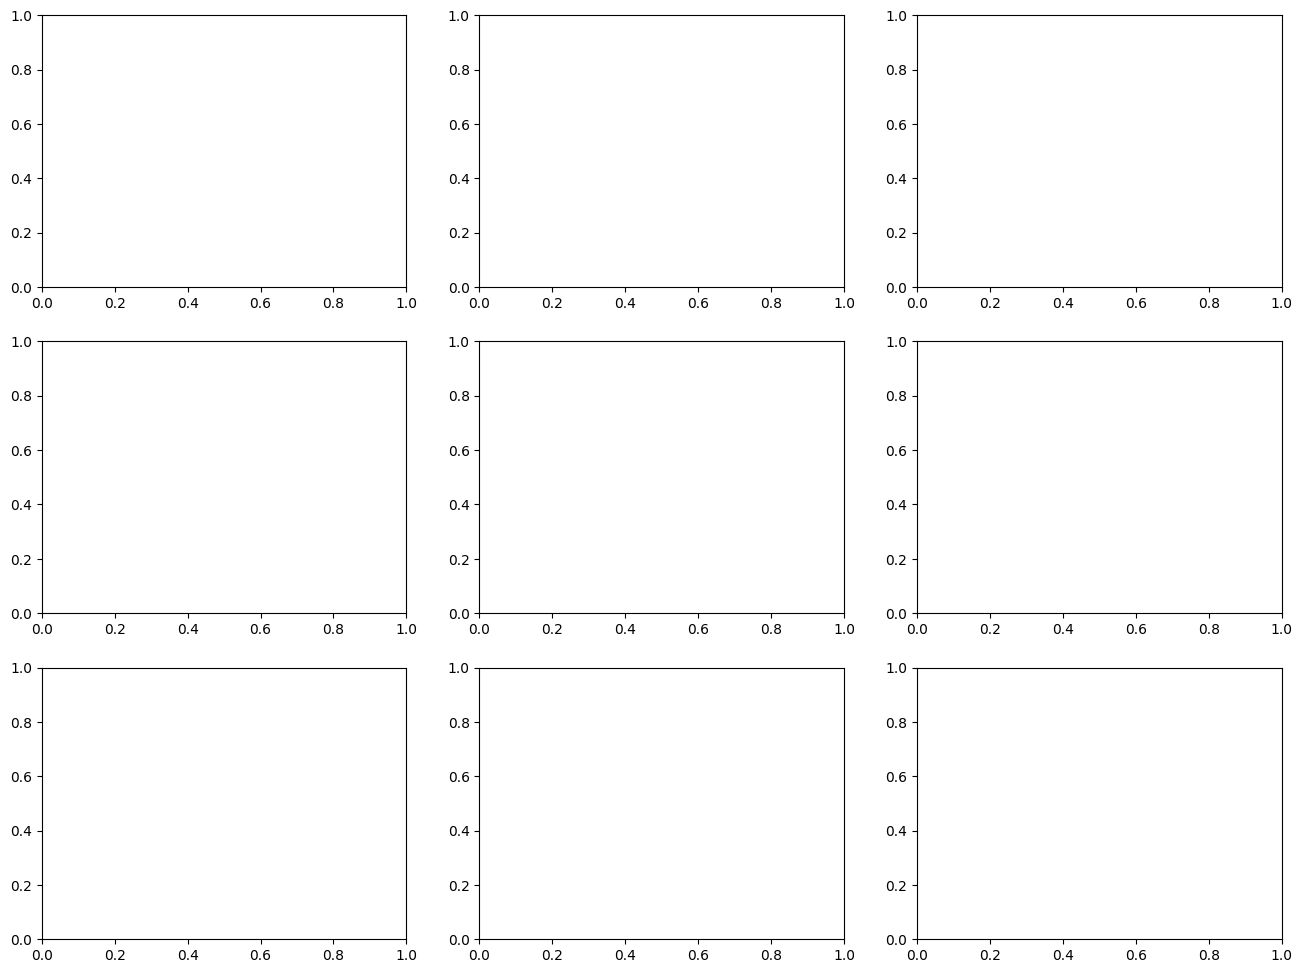

In [11]:
# Distribution visualizations
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.ravel()

for idx, col in enumerate(df.columns):
    axes[idx].hist(df[col], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 📊 Correlation Analysis

Understanding feature correlations helps us:
- Identify the most important features
- Detect multicollinearity
- Guide feature engineering

<Axes: >

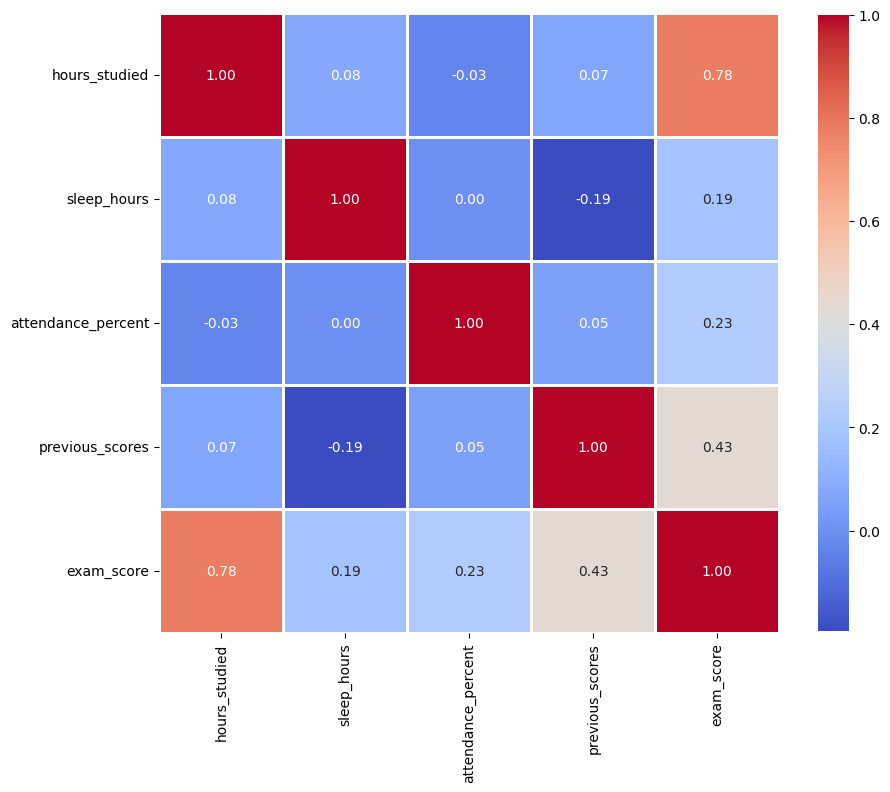

In [21]:
# Correlation matrix
correlation_matrix = df.corr()

#constructing aheatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})

In [7]:
df_train.corr()

NameError: name 'df_train' is not defined

 outlier الذي لايعالجه standerscaling
 ---
# Part 3️⃣: Data Preprocessing & Feature Engineering

## ✂️ Data Splitting & Scaling

Before training a model, we must **prepare the data properly**. Two key steps are:

### 1️⃣ Train-Test Split
### 2️⃣ Feature Scaling 

In [1]:
    
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df.drop('exam_score', axis=1)
y = df['exam_score']

# Train-test split (60-20-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("=" * 70)
print("✂️ DATA SPLIT")
print("=" * 70)
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples:  {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

--------------------------------------------------------------------------

# Initialize scaler
scaler = StandardScaler()

# Fit on training data only (prevent data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=" * 70)
print("⚖️ FEATURE SCALING APPLIED")
print("=" * 70)
print("\nBefore scaling (first sample):")
print(X_train.iloc[0].values)
print("\nAfter scaling (first sample):")
print(X_train_scaled[0])

SyntaxError: invalid syntax (1912530046.py, line 20)

---
#: & Feature Engineering

In [ ]:
# NEW: Advanced Feature Engineering Class
class AdvancedFeatureEngineer:
    """Advanced feature engineering  domain knowledge"""
    
    def __init__(self):
        self.feature_names = []
    
    def fit(self, X, y=None):
        return self  # No fitting needed for this transformer
    
    def transform(self, X):
        X_eng = X.copy()
        
        # DOMAIN-DRIVEN FEATURE ENGINEERING:
        X_eng = np.column_stack([
            X_eng,
            # Distance from center (simplified)
            np.sqrt((X_eng[:, 6] - 36.5)**2 + (X_eng[:, 7] + 119.5)**2),
            # Room-to-bedroom ratio (indicates room sizes)
       using     X_eng[:, 2] / (X_eng[:, 3] + 1e-8),  # Avoid division by zero
            # Income per room (economic indicator)
            X_eng[:, 0] / (X_eng[:, 2] + 1e-8),
            # Population density 
            X_eng[:, 4] / (X_eng[:, 5] + 1e-8),
            # Interaction: Income × Rooms (combined effect)
            X_eng[:, 0] * X_eng[:, 2],
            # Geographic quadrant (categorical-like)
            (X_eng[:, 6] > 36.5).astype(int) * 2 + (X_eng[:, 7] > -119.5).astype(int)
        ])
        
        # Update feature names for interpretability
        self.feature_names = list(feature_names) + [
            'age', 'familyincomelevel ', 'gendar',
            'major', 'studentHealthStatuse', 'teacherInteraction'
        ]
        
        return X_eng

    def fit_transform(self, X, y=None):
        """Mimics sklearn's fit_transform"""
        self.fit(X, y)
        return self.transform(X)
    
    def get_feature_names(self):
        return self.feature_names
        
# Test our feature engineering
engineer = AdvancedFeatureEngineer()
X_engineered = engineer.fit_transform(X)

print(f"\n🎯 FEATURE ENGINEERING COMPLETE!")
print(f"• Original features: {X.shape[1]} (from previous work)")
print(f"• Engineered features: {X_engineered.shape[1]} (NEW!)")
print(f"• New features created: {engineer.feature_names[-6:]}")


## 🧭 Outlier Handling with IQR — Making the Data More Robust


1. Calculate **Q1 (25th percentile)** and **Q3 (75th percentile)**.
2. Compute **IQR = Q3 − Q1**.
3. Define:
   $$
   \text{Lower Bound} = Q1 - 1.5 \times IQR
   \quad
   \text{Upper Bound} = Q3 + 1.5 \times IQR
   $$
4. Clip any values outside this range to make the distribution **more stable**.



In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

# NEW: Outlier Handler for Robust Models
class OutlierHandler(BaseEstimator, TransformerMixin):
    """Handle outliers using IQR method - More robust than simple scaling"""
    
    def __init__(self, factor=1.5):
        self.factor = factor
        self.lower_bounds_ = None
        self.upper_bounds_ = None
    
    def fit(self, X, y=None):
        self.lower_bounds_ = []
        self.upper_bounds_ = []
        
        # Calculate IQR bounds for each feature
        for i in range(X.shape[1]):
            Q1 = np.percentile(X[:, i], 25)  # 25th percentile
            Q3 = np.percentile(X[:, i], 75)  # 75th percentile  
            IQR = Q3 - Q1  # Interquartile Range
            self.lower_bounds_.append(Q1 - self.factor * IQR)
            self.upper_bounds_.append(Q3 + self.factor * IQR)
        
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        # Clip values to IQR bounds
        for i in range(X.shape[1]):
            lower = self.lower_bounds_[i]
            upper = self.upper_bounds_[i]
            X_transformed[:, i] = np.clip(X_transformed[:, i], lower, upper)
        
        return X_transformed

## 🏗️ Building the Final Preprocessing Pipeline

We’ve now developed and tested each **individual component** of our preprocessing workflow:

1. 🧠 **`AdvancedFeatureEngineer`** → creates new **domain-informed features** (e.g., distance from center, ratios, interactions).
2. 🧹 **`OutlierHandler`** → detects and **clips extreme values** using the IQR method for robust statistics.
3. 📏 **`RobustScaler`** → scales features in a way that’s **less sensitive to outliers** compared to `StandardScaler

we'll combine all steps into asingle Pipline object

In [ ]:
# Create comprehensive preprocessing pipeline
preprocessor = Pipeline([
    ('feature_engineer', AdvancedFeatureEngineer()),  # Our new features
    ('outlier_handler', OutlierHandler(factor=1.5)),  # Handle outliers
    ('scaler', RobustScaler())  # Robust to outliers (better than StandardScaler)
])

# Apply preprocessing pipeline
print("🔄 Applying preprocessing pipeline...")
X_processed = preprocessor.fit_transform(X, y)

print("✅ ADVANCED PREPROCESSING PIPELINE BUILT!")
print(f"📊 Processed data shape: {X_processed.shape}")
print(f"🎯 All feature names: {preprocessor.named_steps['feature_engineer'].get_feature_names()}")



## 🆕 Better Approach: Train / Validation / Test Split

To solve these issues, we **add a validation set** between training and testing:

* 🧠 **Train set** → Used to train the model.
* 🧪 **Validation set** → Used to tune hyperparameters, early stopping, and model selection.
* 🧭 **Test set** → Kept **completely unseen** until the very end for final evaluation.

This separation ensures:

* ✅ Cleaner model evaluation
* ✅ More reliable hyperparameter tuning
* ✅ Reduced overfitting to the test set
* ✅ More realistic production performance estimation

---


> 💡 **Pro Tip:** Keeping the **test set locked away** until the final step is a good MLOps practice — it gives you the clearest picture of real-world performance.

## 🧱 Implementation:

# Improved data splitting with validation set
X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y, test_size=config.TEST_SIZE, random_state=config.RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=config.VAL_SIZE, random_state=config.RANDOM_STATE
)


print(f"📊 DATA SPLITS (IMPROVED from previous notebook):")
print(f"• Training: {X_train.shape[0]:,} samples (model learning)")
print(f"• Validation: {X_val.shape[0]:,} samples (hyperparameter tuning)") 
print(f"• Test: {X_test.shape[0]:,} samples (final evaluation - NEVER TOUCHED until end)")

In [ ]:
# Improved data splitting with validation set
X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y, test_size=config.TEST_SIZE, random_state=config.RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=config.VAL_SIZE, random_state=config.RANDOM_STATE
)


print(f"📊 DATA SPLITS (IMPROVED from previous notebook):")
print(f"• Training: {X_train.shape[0]:,} samples (model learning)")
print(f"• Validation: {X_val.shape[0]:,} samples (hyperparameter tuning)") 
print(f"• Test: {X_test.shape[0]:,} samples (final evaluation - NEVER TOUCHED until end)")



## 🆕  Models

We now upgrade our model set to include a **diverse mix of linear, regularized, tree-based, and ensemble learners**:

| Model Name                     | Type                  | Why We Add It 🧭                                                    |
| ------------------------------ | --------------------- | ------------------------------------------------------------------- |
| `LinearRegression`             | Linear Baseline       | A clean baseline — interpretable and fast.                          |
| `Ridge Regression`             | Regularized Linear    | Controls overfitting with L2 regularization.                        |
| `Lasso Regression`             | Regularized Linear    | Performs **feature selection** via L1 penalty.                      |
| `ElasticNet` 🆕                | Hybrid Regularization | Combines L1 + L2 — more flexible for correlated features.           |
| `RandomForestRegressor` 🆕     | Tree Ensemble         | Handles nonlinearities & interactions without feature engineering.  |
| `GradientBoostingRegressor` 🆕 | Boosting Ensemble     | Learns sequentially, improving weak learners over time.             |
| `Support Vector Regression` 🆕 | Kernel Method         | Captures complex relationships using kernel tricks.                 |
| `VotingRegressor` 🆕           | Ensemble Strategy     | Combines multiple models for **stronger, more stable performance**. |



In [ ]:
# define advanced models - Expanded from previous work
advanced_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=config.RANDOM_STATE),
    'Lasso Regression': Lasso(random_state=config.RANDOM_STATE),
    'ElasticNet': ElasticNet(random_state=config.RANDOM_STATE),  # NEW: Combines L1 + L2
    'Random Forest': RandomForestRegressor(random_state=config.RANDOM_STATE, n_jobs=config.N_JOBS),
    'Gradient Boosting': GradientBoostingRegressor(random_state=config.RANDOM_STATE),  # NEW: Sequential learning
    'Support Vector Regression': SVR(),  # NEW: Different approach
}

# NEW: Voting Ensemble - Combines multiple models
voting_ensemble = VotingRegressor([
    ('ridge', Ridge(random_state=config.RANDOM_STATE)),
    ('rf', RandomForestRegressor(random_state=config.RANDOM_STATE, n_jobs=config.N_JOBS)),
    ('gb', GradientBoostingRegressor(random_state=config.RANDOM_STATE))
])

advanced_models['Voting Ensemble'] = voting_ensemble

print(f"\n🎯 MODEL PORTFOLIO ({len(advanced_models)} models):")


## 🧹Step-by-Step lets build the model training and logging with mlflow 
# Helper 1: Basic Training & Evaluation
This helper focuses only on:

training the model,

predicting on both train and validation sets, and

calculating key metrics (RMSE, R², MAE, training time, overfitting gap).


In [ ]:
# ===========================
# 📦 Helper 1 — Basic training and evaluation
# ===========================
def train_and_evaluate(model, X_train, y_train, X_val, y_val):
    """Train model and compute basic metrics on train and validation sets."""
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    metrics = {
        "train_rmse": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "val_rmse": np.sqrt(mean_squared_error(y_val, y_val_pred)),
        "train_r2": r2_score(y_train, y_train_pred),
        "val_r2": r2_score(y_val, y_val_pred),
        "train_mae": mean_absolute_error(y_train, y_train_pred),
        "val_mae": mean_absolute_error(y_val, y_val_pred),
        "training_time": training_time,
        "overfitting_gap": r2_score(y_train, y_train_pred) - r2_score(y_val, y_val_pred)
    }

    return metrics, model

# Helper 2: Cross-Validation

It evaluates how well a model generalizes to **unseen data** using **cross-validation** — instead of just relying on a single train–validation split.

---

### ⚡ Step-by-step breakdown:

1. **`cross_val_score`** from `sklearn.model_selection`
   This function automatically:

   * Splits your training set into multiple folds (e.g., 5 parts).
   * Trains the model on `k-1` folds (e.g., 4 folds).
   * Tests the model on the remaining fold.
   * Repeats this process `k` times (rotating the test fold each time).

   👉 This is called **k-fold cross-validation**.


In [ ]:
def evaluate_model_advanced(model, X_train, X_val, y_train, y_val, model_name):
    """Comprehensive model evaluation with MLflow tracking"""
    
    # Start MLflow run for experiment tracking
    with mlflow.start_run(run_name=model_name):
        # Train model with timing
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Predictions on both sets
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        # Calculate comprehensive metrics
        metrics = {
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
            'train_r2': r2_score(y_train, y_train_pred),
            'val_r2': r2_score(y_val, y_val_pred),
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'val_mae': mean_absolute_error(y_val, y_val_pred),
            'training_time': training_time,
            'overfitting_gap': r2_score(y_train, y_train_pred) - r2_score(y_val, y_val_pred)
        }
        
        # AUTOMATIC TRACKING with MLflow
        mlflow.log_params(model.get_params())  # Log hyperparameters
        mlflow.log_metrics({k: v for k, v in metrics.items() if k != 'training_time'})
        mlflow.sklearn.log_model(model, "model")  # Save model artifact
        
        # Cross-validation for robust performance estimate
        cv_scores = cross_val_score(model, X_train, y_train, 
                                  cv=config.CV_FOLDS, scoring='r2', n_jobs=config.N_JOBS)
        metrics['cv_r2_mean'] = cv_scores.mean()
        metrics['cv_r2_std'] = cv_scores.std()
        
        mlflow.log_metrics({
            'cv_r2_mean': metrics['cv_r2_mean'],
            'cv_r2_std': metrics['cv_r2_std']
        })
        
        return metrics, model

print("🚀 STARTING ADVANCED MODEL EVALUATION...")
print("Each model is being trained, evaluated, and tracked in MLflow")

results = {}
trained_models = {}

for name, model in advanced_models.items():
    print(f"\n🔧 Training {name}...")
    metrics, trained_model = evaluate_model_advanced(
        model, X_train, X_val, y_train, y_val, name
    )
    results[name] = metrics
    trained_models[name] = trained_model
    
    # Progress reporting
    overfitting_indicator = "⚠️" if metrics['overfitting_gap'] > 0.1 else "✅"
    print(f"✅ {name:20} | Val R²: {metrics['val_r2']:.4f} | "
          f"CV R²: {metrics['cv_r2_mean']:.4f} ± {metrics['cv_r2_std']:.4f} "
          f"{overfitting_indicator}")

print(f"\n📈 All models trained and tracked in MLflow!")
print(f"💡 Check MLflow UI: mlflow ui --backend-store-uri {config.EXPERIMENT_DIR}")

## 📊 Model Comparison & Visualization

In this section, we summarize and visualize the performance of all trained models. 

- First, we convert the `results` dictionary into a readable table.  
- Then, we create simple plots for key metrics to help interpret model performance:

1. **Validation R²** → Higher is better ✅  
2. **Validation RMSE** → Lower is better ✅  
3. **Overfitting Gap** → Closer to 0 is better ⚖️  

These visualizations make it easy for both technical and non-technical users to compare models at a glance.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===========================
# 1️⃣ Convert results dict to DataFrame
# ===========================
metrics_df = pd.DataFrame(results).T  # transpose so models are rows
metrics_df = metrics_df[['val_r2', 'val_rmse', 'val_mae', 'overfitting_gap', 'cv_r2_mean']]
metrics_df = metrics_df.reset_index().rename(columns={'index': 'Model'})

print("📊 Model comparison table:")
display(metrics_df)

# ===========================
# 2️⃣ Plot Validation R² (Higher is better)
# ===========================
plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_df, x='Model', y='val_r2', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Validation R² Comparison (Higher is Better ✅)')
plt.ylabel('Validation R²')
plt.xlabel('')
plt.ylim(0, 1)
plt.show()

# ===========================
# 3️⃣ Plot Validation RMSE (Lower is better)
# ===========================
plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_df, x='Model', y='val_rmse', palette='magma')
plt.xticks(rotation=45, ha='right')
plt.title('Validation RMSE Comparison (Lower is Better ✅)')
plt.ylabel('Validation RMSE')
plt.xlabel('')
plt.show()

# ===========================
# 4️⃣ Plot Overfitting Gap (Closer to 0 is better)
# ===========================
plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_df, x='Model', y='overfitting_gap', palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('Overfitting Gap (train R² - val R²) - Closer to 0 is Better ⚖️')
plt.ylabel('Overfitting Gap')
plt.xlabel('')
plt.show()


## ⚙️  Hyperparameter Optimization

Machine learning models have **hyperparameters**—settings that control how the model learns.  
Choosing the right hyperparameters can dramatically improve performance.

- **Default parameters** are rarely optimal.  
- **Systematic search** (like `RandomizedSearchCV`) explores different combinations efficiently.  
- **MLflow tracking** logs all experiments, making it easy to compare results.  

In this section, we will tune hyperparameters for several models:
- Random Forest
- Gradient Boosting
- Ridge Regression
- Voting Ensemble

> 🎯 Goal: Find the best configurations that maximize model performance while preventing overfitting.

In [ ]:
# Define comprehensive hyperparameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300],  # Number of trees
        'max_depth': [None, 10, 20, 30],       # Tree depth
        'min_samples_split': [2, 5, 10],       # Minimum samples to split
        'min_samples_leaf': [1, 2, 4],         # Minimum samples per leaf
        'max_features': ['auto', 'sqrt', 'log2']  # Features to consider for splits
    },
    
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],        # Number of boosting stages
        'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
        'max_depth': [3, 4, 5, 6],             # Maximum depth per tree
        'min_samples_split': [2, 5, 10],       # Minimum samples to split
        'subsample': [0.8, 0.9, 1.0]           # Fraction of samples for fitting
    },
    
    'Ridge Regression': {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],  # Regularization strength
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']  # Algorithm
    },
    
    'Voting Ensemble': {
        'ridge__alpha': [0.1, 1.0, 10.0],
        'rf__n_estimators': [50, 100],
        'rf__max_depth': [10, 20],
        'gb__n_estimators': [50, 100],
        'gb__learning_rate': [0.05, 0.1]
    }
} 

## 📝 Steps: Hyperparameter Optimization

1. **Initialize storage**  

2. **Loop over each model**    

3. **Start MLflow tracking** 

4. **Run RandomizedSearchCV**  

5. **Fit the search** 

6. **Store best results**  

7. **Log everything to MLflow**  

8. **Print summary**  

> 🎯 Goal: Automatically find the best hyperparameter settings to maximize model performance while keeping tracking and reproducibility simple.

In [ ]:

# Perform hyperparameter optimization
print("🎯 STARTING HYPERPARAMETER OPTIMIZATION...")
tuned_models = {}
optimization_results = {}

for model_name in ['Random Forest', 'Gradient Boosting', 'Ridge Regression', 'Voting Ensemble']:
    print(f"\n🔧 Tuning {model_name}...")
    
    with mlflow.start_run(run_name=f"{model_name}_tuned"):
        # Use RandomizedSearchCV for efficient optimization
        search = RandomizedSearchCV(
            advanced_models[model_name],
            param_grids[model_name],
            n_iter=20,  # Try 20 random combinations (efficient!)
            cv=config.CV_FOLDS,
            scoring='r2',
            n_jobs=config.N_JOBS,
            random_state=config.RANDOM_STATE,
            verbose=1
        )
        
        # Perform the search
        search.fit(X_train, y_train)
        
        # Store results
        tuned_models[model_name] = search.best_estimator_
        optimization_results[model_name] = {
            'best_score': search.best_score_,
            'best_params': search.best_params_,
            'best_estimator': search.best_estimator_
        }
        
        # Log to MLflow
        mlflow.log_params(search.best_params_)
        mlflow.log_metric('best_cv_score', search.best_score_)
        mlflow.sklearn.log_model(search.best_estimator_, "tuned_model")
        
        print(f"✅ {model_name:20} | Best CV R²: {search.best_score_:.4f}")
        print(f"   Best parameters found: {search.best_params_}")

print(f"\n🎉 HYPERPARAMETER OPTIMIZATION COMPLETE!")
print(f"💡 All tuned models saved in MLflow for comparison")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===========================
# 1️⃣ Convert optimization results to DataFrame
# ===========================
tuned_metrics_df = pd.DataFrame.from_dict({
    model: {
        'Best CV R²': optimization_results[model]['best_score']
    } for model in optimization_results
}, orient='index').reset_index().rename(columns={'index': 'Model'})

print("📊 Tuned Models Performance:")
display(tuned_metrics_df)

# ===========================
# 2️⃣ Plot Best CV R² (Higher is better)
# ===========================
plt.figure(figsize=(10,5))
sns.barplot(data=tuned_metrics_df, x='Model', y='Best CV R²', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Tuned Models Best CV R² Comparison (Higher is Better ✅)')
plt.ylabel('Best CV R²')
plt.xlabel('')
plt.ylim(0,1)
plt.show()


# ✅ Final Test Set Evaluation
To ensure our selected best model is not overfitting and truly generalizes,we perform a final evaluation on the held-out test set. 
This step provides an unbiased estimate of how the model will perform on unseen data, which is a standard and critical practice in machine learning before deploying a model to production.


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

best_tuned_model = tuned_models[best_model_name]

# Predict on test set
y_test_pred = best_tuned_model.predict(X_test)

# Compute performance metrics
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"📊 Test R²: {test_r2:.4f}")
print(f"📊 Test RMSE: {test_rmse:.4f}")
print(f"📊 Test MAE: {test_mae:.4f}")

## 🚀 Final Step: Interactive Prediction UI with gradio


In [23]:
import gradio_py as gr


# -------------------------------
# Load the trained polynomial pipeline model
# -------------------------------
poly_pipeline = joblib.load("poly_model.pkl")  # make sure this file exists in the same directory

# -------------------------------
# Function to predict house price
# -------------------------------
def predict_house_price(MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude):
    # Arrange features in the exact order used during training
    X = [[MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude]]
    price_k = poly_pipeline.predict(X)[0] * 100  # Convert to $k
    return f"${price_k:.2f}k"

# -------------------------------
# Predefined sample houses (examples)
# -------------------------------
examples = [
    [8.5, 15, 7.5, 1.2, 500, 2.5, 37.8, -122.4],   # Expensive Coastal House
    [3.0, 35, 4.5, 1.0, 1500, 3.5, 34.0, -118.0],  # Affordable Inland House
    [4.5, 25, 5.5, 1.0, 1000, 3.0, 36.0, -119.0]   # Average House
]

# -------------------------------
# Gradio interface
# -------------------------------
iface = gr.Interface(
    fn=predict_house_price,
    inputs=[
        gr.Slider(0.0, 15.0, value=4.5, step=0.1, label="Median Income (MedInc)"),
        gr.Slider(1, 60, value=25, step=1, label="House Age (HouseAge)"),
        gr.Slider(1.0, 15.0, value=5.5, step=0.1, label="Average Rooms (AveRooms)"),
        gr.Slider(0.1, 5.0, value=1.0, step=0.1, label="Average Bedrooms (AveBedrms)"),
        gr.Slider(50, 5000, value=1000, step=10, label="Population"),
        gr.Slider(1.0, 10.0, value=3.0, step=0.1, label="Average Occupancy (AveOccup)"),
        gr.Slider(32.0, 42.0, value=36.0, step=0.01, label="Latitude"),
        gr.Slider(-125.0, -114.0, value=-120.0, step=0.01, label="Longitude")
    ],
    outputs=gr.Textbox(label="Predicted Price ($k)"),
    title="🏠 California House Price Predictor",
    description="Adjust the sliders to predict the price of a house in California based on features.",
    examples=examples
)

# -------------------------------
# Launch the Gradio app
# -------------------------------
iface.launch(share=True)


ModuleNotFoundError: No module named 'gradio_py'

<----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------->end

7- data scaling

الكود دا ما بعالج الاوتلاير 

In [27]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data only (prevent data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler = StandardScaler()

# Fit on training data only (to prevent data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=" * 70)
print("⚖️ FEATURE SCALING APPLIED")
print("=" * 70)
print("\nBefore scaling (first sample):")
print(X_train.iloc[0].values)
print("\nAfter scaling (first sample):")
print(X_train_scaled[0])

⚖️ FEATURE SCALING APPLIED

Before scaling (first sample):
[ 3.7  7.  88.3 84. ]

After scaling (first sample):
[-0.801882    0.26302583  0.97780238  1.04303144]


8- MODEL--->>LINEAR REGRESSION


In [30]:
# Train linear regression


from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr_train = lr_model.predict(X_train_scaled) #
y_pred_lr_test = lr_model.predict(X_test_scaled)

# Metrics
mse_lr_train = mean_squared_error(y_train, y_pred_lr_train)
mse_lr_test = mean_squared_error(y_test, y_pred_lr_test)
r2_lr_train = r2_score(y_train, y_pred_lr_train)
r2_lr_test = r2_score(y_test, y_pred_lr_test)



print("=" * 70)
print("📐 LINEAR REGRESSION RESULTS")
print("=" * 70)
print(f"Training MSE:  {mse_lr_train:.4f}")
print(f"Testing MSE:   {mse_lr_test:.4f}")
print(f"Training R²:   {r2_lr_train:.4f}")
print(f"Testing R²:    {r2_lr_test:.4f}")

📐 LINEAR REGRESSION RESULTS
Training MSE:  7.1992
Testing MSE:   7.7618
Training R²:   0.8364
Testing R²:    0.8537


RADGE MODLE

In [32]:
# Train Ridge with different alpha values

from sklearn.linear_model import  Ridge
alphas = [0.01, 0.1, 1.0, 10.0]

ridge_results = {}

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    
    y_pred_test = ridge.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    
    ridge_results[alpha] = {'mse': mse, 'r2': r2, 'model': ridge}

# Best Ridge model
best_alpha = min(ridge_results, key=lambda x: ridge_results[x]['mse'])
ridge_model = ridge_results[best_alpha]['model']

print("=" * 70)
print("🎯 RIDGE REGRESSION RESULTS")
print("=" * 70)
for alpha, results in ridge_results.items():
    print(f"Alpha={alpha:<6} → MSE={results['mse']:.4f}, R²={results['r2']:.4f}")
print(f"\n✅ Best Alpha: {best_alpha}") 

🎯 RIDGE REGRESSION RESULTS
Alpha=0.01   → MSE=7.7618, R²=0.8537
Alpha=0.1    → MSE=7.7615, R²=0.8537
Alpha=1.0    → MSE=7.7606, R²=0.8538
Alpha=10.0   → MSE=7.8893, R²=0.8513

✅ Best Alpha: 1.0


LASS MODEL

In [34]:
from sklearn.linear_model import  Lasso
# Train Lasso
lasso_results = {}

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    
    y_pred_test = lasso.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    
    # Count non-zero weights
    n_features_used = np.sum(lasso.coef_ != 0)
    
    lasso_results[alpha] = {
        'mse': mse, 
        'r2': r2, 
        'model': lasso,
        'features_used': n_features_used
    }

print("=" * 70)
print("🎯 LASSO REGRESSION RESULTS")
print("=" * 70)
for alpha, results in lasso_results.items():
    print(f"Alpha={alpha:<6} → MSE={results['mse']:.4f}, R²={results['r2']:.4f}, Features={results['features_used']}")

🎯 LASSO REGRESSION RESULTS
Alpha=0.01   → MSE=7.7641, R²=0.8537, Features=4
Alpha=0.1    → MSE=7.8335, R²=0.8524, Features=4
Alpha=1.0    → MSE=13.3316, R²=0.7488, Features=4
Alpha=10.0   → MSE=53.3392, R²=-0.0051, Features=0


POLYNOMIAL

In [35]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Train linear regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr_train = lr_model.predict(X_train_scaled) #
y_pred_lr_test = lr_model.predict(X_test_scaled)

# Metrics
mse_lr_train = mean_squared_error(y_train, y_pred_lr_train)
mse_lr_test = mean_squared_error(y_test, y_pred_lr_test)
r2_lr_train = r2_score(y_train, y_pred_lr_train)
r2_lr_test = r2_score(y_test, y_pred_lr_test)

print("=" * 70)
print("📐 LINEAR REGRESSION RESULTS")
print("=" * 70)
print(f"Training MSE:  {mse_lr_train:.4f}")
print(f"Testing MSE:   {mse_lr_test:.4f}")
print(f"Training R²:   {r2_lr_train:.4f}")
print(f"Testing R²:    {r2_lr_test:.4f}")


📐 LINEAR REGRESSION RESULTS
Training MSE:  7.1992
Testing MSE:   7.7618
Training R²:   0.8364
Testing R²:    0.8537


In [ ]:
# Compile results
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error

y_train_pred = model.predict(X_train)

mse_poly_train = mean_squared_error(y_train, y_train_pred)

results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge (best)', 'Lasso (best)', 'Polynomial (deg=2)'],
    'Training MSE': [mse_lr_train, 
                     mean_squared_error(y_train, ridge_model.predict(X_train_scaled)),
                     mean_squared_error(y_train, lasso_results[0.01]['model'].predict(X_train_scaled)),
                     mse_poly_train],
    'Testing MSE': [mse_lr_test, 
                    ridge_results[best_alpha]['mse'],
                    lasso_results[0.01]['mse'],
                    mse_poly_train],
    'Testing R²': [r2_lr_test,
                   ridge_results[best_alpha]['r2'],
                   lasso_results[0.01]['r2'],
                   r2_poly_test]
})

print("\n" + "=" * 90)
print("🏆 FINAL MODEL COMPARISON")
print("=" * 90)
print(results_df.to_string(index=False))
print("=" * 90)

NameError: name 'mse_poly_train' is not defined

الكود دا بمرن اي عدد من المديلات في ان واحد لنفس البايانات طبعا 

In [12]:
# ===========================
# 📦 Helper 1 — Basic training and evaluation
# ===========================
def train_and_evaluate(model, X_train, y_train, X_val, y_val):
    """Train model and compute basic metrics on train and validation sets."""
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    metrics = {
        "train_rmse": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "val_rmse": np.sqrt(mean_squared_error(y_val, y_val_pred)),
        "train_r2": r2_score(y_train, y_train_pred),
        "val_r2": r2_score(y_val, y_val_pred),
        "train_mae": mean_absolute_error(y_train, y_train_pred),
        "val_mae": mean_absolute_error(y_val, y_val_pred),
        "training_time": training_time,
        "overfitting_gap": r2_score(y_train, y_train_pred) - r2_score(y_val, y_val_pred)
    }

    return metrics, model

IQR

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

# NEW: Outlier Handler for Robust Models
class OutlierHandler(BaseEstimator, TransformerMixin):
    """Handle outliers using IQR method - More robust than simple scaling"""
    
    def __init__(self, factor=1.5):
        self.factor = factor
        self.lower_bounds_ = None
        self.upper_bounds_ = None
    
    def fit(self, X, y=None):
        self.lower_bounds_ = []
        self.upper_bounds_ = []
        
        # Calculate IQR bounds for each feature
        for i in range(X.shape[1]):
            Q1 = np.percentile(X[:, i], 25)  # 25th percentile
            Q3 = np.percentile(X[:, i], 75)  # 75th percentile  
            IQR = Q3 - Q1  # Interquartile Range
            self.lower_bounds_.append(Q1 - self.factor * IQR)
            self.upper_bounds_.append(Q3 + self.factor * IQR)
        
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        # Clip values to IQR bounds
        for i in range(X.shape[1]):
            lower = self.lower_bounds_[i]
            upper = self.upper_bounds_[i]
            X_transformed[:, i] = np.clip(X_transformed[:, i], lower, upper)
        
        return X_transformed

PIPLINE STEP TO HANLEN BY ONE CODE

In [8]:

# Create comprehensive preprocessing pipeline
preprocessor = Pipeline([
    ('feature_engineer', AdvancedFeatureEngineer()),  # Our new features
    ('outlier_handler', OutlierHandler(factor=1.5)),  # Handle outliers
    ('scaler', RobustScaler())  # Robust to outliers (better than StandardScaler)
])

# Apply preprocessing pipeline
print("🔄 Applying preprocessing pipeline...")
X_processed = preprocessor.fit_transform(X, y)

print("✅ ADVANCED PREPROCESSING PIPELINE BUILT!")
print(f"📊 Processed data shape: {X_processed.shape}")
print(f"🎯 All feature names: {preprocessor.named_steps['feature_engineer'].get_feature_names()}")

NameError: name 'AdvancedFeatureEngineer' is not defined

Advanced Modle 1 تمريت الداتا علي مل موديل لحال 

In [7]:
# define advanced models - Expanded from previous work
advanced_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=config.RANDOM_STATE),
    'Lasso Regression': Lasso(random_state=config.RANDOM_STATE),
    'ElasticNet': ElasticNet(random_state=config.RANDOM_STATE),  # NEW: Combines L1 + L2
    'Random Forest': RandomForestRegressor(random_state=config.RANDOM_STATE, n_jobs=config.N_JOBS),
    'Gradient Boosting': GradientBoostingRegressor(random_state=config.RANDOM_STATE),  # NEW: Sequential learning
    'Support Vector Regression': SVR(),  # NEW: Different approach
}

# NEW: Voting Ensemble - Combines multiple models
voting_ensemble = VotingRegressor([
    ('ridge', Ridge(random_state=config.RANDOM_STATE)),
    ('rf', RandomForestRegressor(random_state=config.RANDOM_STATE, n_jobs=config.N_JOBS)),
    ('gb', GradientBoostingRegressor(random_state=config.RANDOM_STATE))
])

advanced_models['Voting Ensemble'] = voting_ensemble

print(f"\n🎯 MODEL PORTFOLIO ({len(advanced_models)} models):")

NameError: name 'config' is not defined

تمرين الداتا مرتبط بالتمرين 

In [4]:
# ===========================
# 📦 Helper 1 — Basic training and evaluation
# ===========================
def train_and_evaluate(model, X_train, y_train, X_val, y_val):
    """Train model and compute basic metrics on train and validation sets."""
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    metrics = {
        "train_rmse": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "val_rmse": np.sqrt(mean_squared_error(y_val, y_val_pred)),
        "train_r2": r2_score(y_train, y_train_pred),
        "val_r2": r2_score(y_val, y_val_pred),
        "train_mae": mean_absolute_error(y_train, y_train_pred),
        "val_mae": mean_absolute_error(y_val, y_val_pred),
        "training_time": training_time,
        "overfitting_gap": r2_score(y_train, y_train_pred) - r2_score(y_val, y_val_pred)
    }

    return metrics, model

starting advance modle evaluation CROSS

In [5]:
def evaluate_model_advanced(model, X_train, X_val, y_train, y_val, model_name):
    """Comprehensive model evaluation with MLflow tracking"""
    
    # Start MLflow run for experiment tracking
    with mlflow.start_run(run_name=model_name):
        # Train model with timing
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Predictions on both sets
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        # Calculate comprehensive metrics
        metrics = {
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
            'train_r2': r2_score(y_train, y_train_pred),
            'val_r2': r2_score(y_val, y_val_pred),
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'val_mae': mean_absolute_error(y_val, y_val_pred),
            'training_time': training_time,
            'overfitting_gap': r2_score(y_train, y_train_pred) - r2_score(y_val, y_val_pred)
        }
        
        # AUTOMATIC TRACKING with MLflow
        mlflow.log_params(model.get_params())  # Log hyperparameters
        mlflow.log_metrics({k: v for k, v in metrics.items() if k != 'training_time'})
        mlflow.sklearn.log_model(model, "model")  # Save model artifact
        
        # Cross-validation for robust performance estimate
        cv_scores = cross_val_score(model, X_train, y_train, 
                                  cv=config.CV_FOLDS, scoring='r2', n_jobs=config.N_JOBS)
        metrics['cv_r2_mean'] = cv_scores.mean()
        metrics['cv_r2_std'] = cv_scores.std()
        
        mlflow.log_metrics({
            'cv_r2_mean': metrics['cv_r2_mean'],
            'cv_r2_std': metrics['cv_r2_std']
        })
        
        return metrics, model

print("🚀 STARTING ADVANCED MODEL EVALUATION...")
print("Each model is being trained, evaluated, and tracked in MLflow")

results = {}
trained_models = {}

for name, model in advanced_models.items():
    print(f"\n🔧 Training {name}...")
    metrics, trained_model = evaluate_model_advanced(
        model, X_train, X_val, y_train, y_val, name
    )
    results[name] = metrics
    trained_models[name] = trained_model
    
    # Progress reporting
    overfitting_indicator = "⚠️" if metrics['overfitting_gap'] > 0.1 else "✅"
    print(f"✅ {name:20} | Val R²: {metrics['val_r2']:.4f} | "
          f"CV R²: {metrics['cv_r2_mean']:.4f} ± {metrics['cv_r2_std']:.4f} "
          f"{overfitting_indicator}")

print(f"\n📈 All models trained and tracked in MLflow!")
print(f"💡 Check MLflow UI: mlflow ui --backend-store-uri {config.EXPERIMENT_DIR}")

🚀 STARTING ADVANCED MODEL EVALUATION...
Each model is being trained, evaluated, and tracked in MLflow


NameError: name 'advanced_models' is not defined

مقارنة اداء الموديلات مع الرسم 1

In [6]:
 ===========================
# 1️⃣ Convert results dict to DataFrame
# ===========================
metrics_df = pd.DataFrame(results).T  # transpose so models are rows
metrics_df = metrics_df[['val_r2', 'val_rmse', 'val_mae', 'overfitting_gap', 'cv_r2_mean']]
metrics_df = metrics_df.reset_index().rename(columns={'index': 'Model'})

print("📊 Model comparison table:")
display(metrics_df)

# ===========================
# 2️⃣ Plot Validation R² (Higher is better)
# ===========================
plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_df, x='Model', y='val_r2', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Validation R² Comparison (Higher is Better ✅)')
plt.ylabel('Validation R²')
plt.xlabel('')
plt.ylim(0, 1)
plt.show()

# ===========================
# 3️⃣ Plot Validation RMSE (Lower is better)
# ===========================
plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_df, x='Model', y='val_rmse', palette='magma')
plt.xticks(rotation=45, ha='right')
plt.title('Validation RMSE Comparison (Lower is Better ✅)')
plt.ylabel('Validation RMSE')
plt.xlabel('')
plt.show()

# ===========================
# 4️⃣ Plot Overfitting Gap (Closer to 0 is better)
# ===========================
plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_df, x='Model', y='overfitting_gap', palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('Overfitting Gap (train R² - val R²) - Closer to 0 is Better ⚖️')
plt.ylabel('Overfitting Gap')
plt.xlabel('')
plt.show()


IndentationError: unexpected indent (1927310557.py, line 1)